In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov7-main

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/yolov7-main


In [2]:
#%pip install -qr requirements.txt # install dependencies or no need
import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.8.0+cu126 (CPU)


In [3]:
import matplotlib.pyplot as plt
import torch
import cv2
import random
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device, weights_only=False)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [ ]:
image = cv2.imread('inference/images/bus.jpg')
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)
output, _ = model(image)

In [8]:
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_keypoint(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

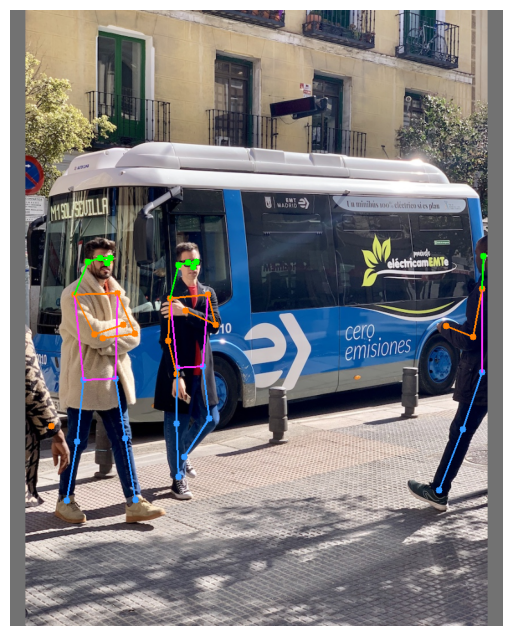

In [9]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


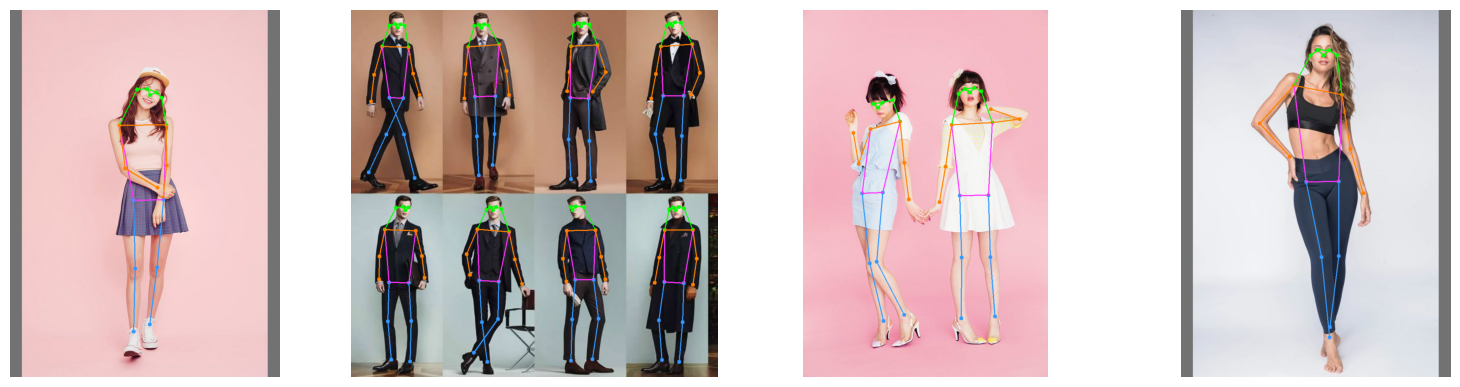

In [5]:
# --- Config ---
val_dir = "pose-tests/"

num_samples = 4

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []
%matplotlib inline

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idximg, (img_name, img_path, img_rgb) in enumerate(img_list):
    image = cv2.imread(img_path)
    h_orig, w_orig = image.shape[:2]

    image = letterbox(image, 960, stride=64, auto=True)[0]
    image_ = image.copy()
    image = transforms.ToTensor()(image)
    image = torch.tensor(np.array([image.numpy()]))

    if torch.cuda.is_available():
        image = image.half().to(device)
    output, _ = model(image)

    output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    plt.subplot(rows, cols, idximg + 1)
    plt.imshow(nimg)
    plt.axis('off')

plt.tight_layout()
plt.show()